In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

data_dir = "./data/"

2023-11-28 10:50:10.514581: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 10:50:10.986915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 10:50:10.986992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 10:50:11.080051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 10:50:11.263502: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 10:50:11.267218: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'LICENSE') & \
                    (commands != 'validation_list.txt') & (commands != 'testing_list.txt')]
print('Commands:', commands)

Commands: ['tree' 'bed' 'one' 'four' 'go' 'off' '_background_noise_' 'right' 'six'
 'happy' 'sheila' 'five' 'down' 'cat' 'three' 'no' 'left' 'two' 'bird'
 'on' 'marvin' 'zero' 'nine' 'dog' 'stop' 'house' 'seven' 'up' 'eight'
 'wow' 'yes']


In [3]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


In [4]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [5]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [6]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [7]:
label_names[[1,4,3,6]]

array(['bed', 'dog', 'cat', 'eight'], dtype='<U18')

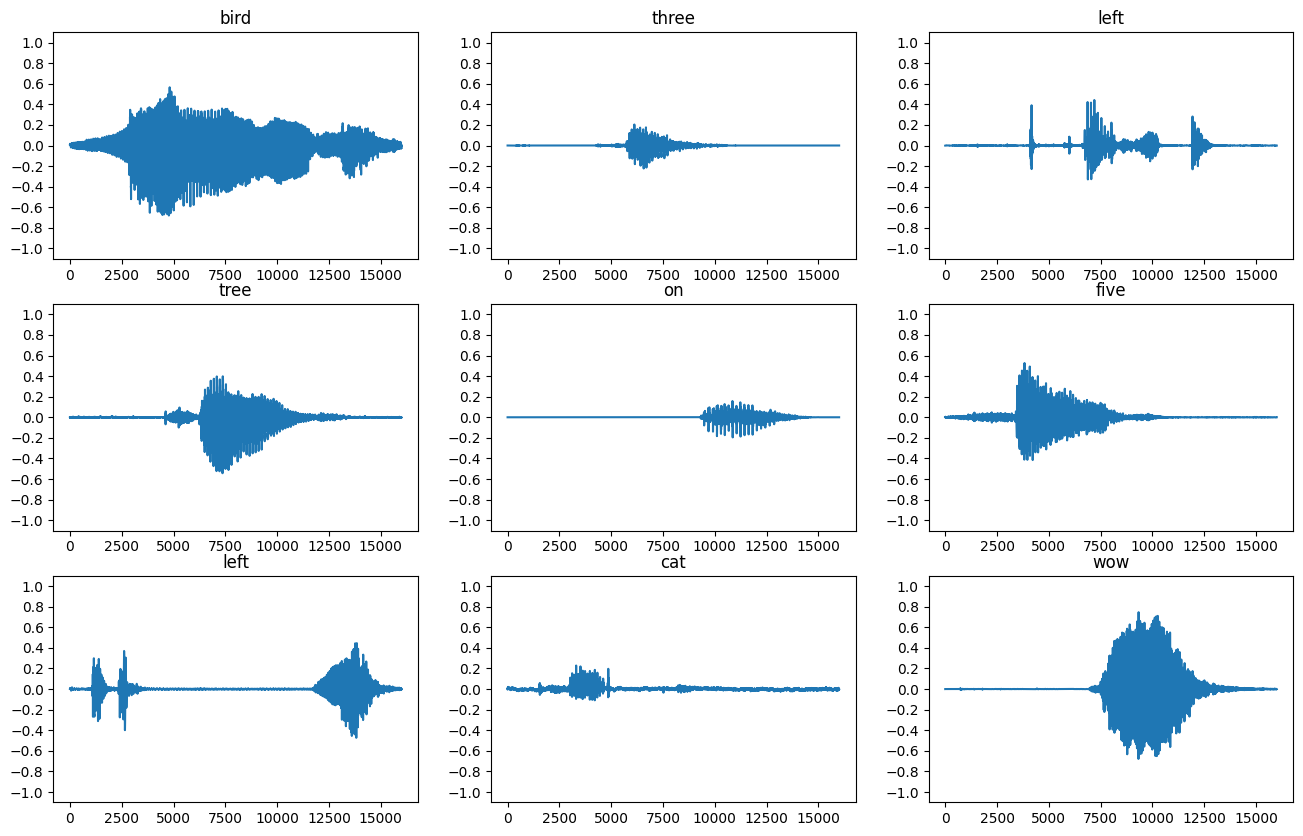

In [8]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [9]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [10]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [11]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

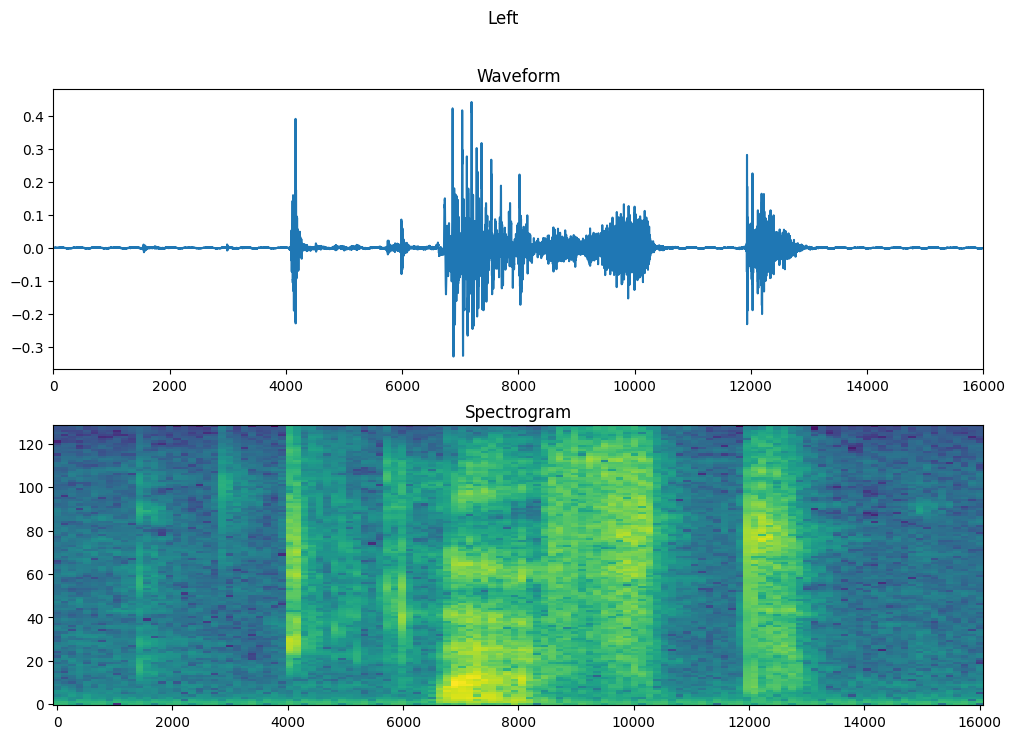

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [13]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [15]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

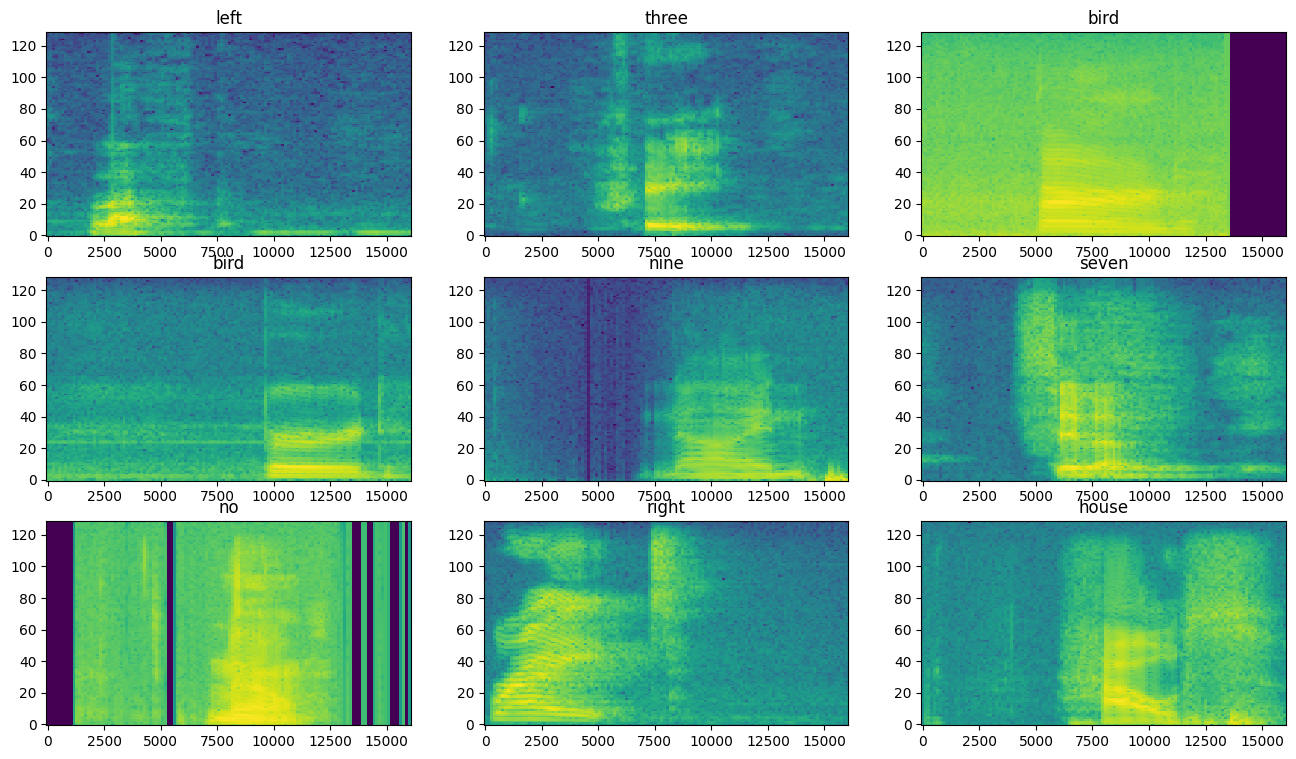

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

In [19]:
def RNN(input_shape, num_labels, norm_layer):

    model = models.Sequential([
        layers.Input(shape=input_shape),
        norm_layer,
        layers.Lambda(lambda q: tf.squeeze(q, -1), name='squeeze_last_dim'),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(32),
        layers.Dense(num_labels, activation='softmax'),
    ])
    
    model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])

    model.summary()
    
    return model

In [20]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (124, 129, 1)


In [21]:
model = RNN(input_shape, num_labels, norm_layer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 124, 129, 1)       3         
 on)                                                             
                                                                 
 squeeze_last_dim (Lambda)   (None, 124, 129)          0         
                                                                 
 lstm (LSTM)                 (None, 124, 64)           49664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [22]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


810/810 [==============================] - 111s 132ms/step - loss: 2.7432 - accuracy: 0.1708 - val_loss: 2.2311 - val_accuracy: 0.2870
Epoch 2/10
810/810 [==============================] - 106s 130ms/step - loss: 1.9116 - accuracy: 0.3936 - val_loss: 1.5551 - val_accuracy: 0.5090
Epoch 3/10
810/810 [==============================] - 107s 132ms/step - loss: 1.1885 - accuracy: 0.6364 - val_loss: 0.8936 - val_accuracy: 0.7321
Epoch 4/10
810/810 [==============================] - 106s 131ms/step - loss: 0.7486 - accuracy: 0.7758 - val_loss: 0.6532 - val_accuracy: 0.8063
Epoch 5/10
810/810 [==============================] - 105s 129ms/step - loss: 0.5586 - accuracy: 0.8324 - val_loss: 0.5173 - val_accuracy: 0.8518
Epoch 6/10
810/810 [==============================] - 106s 130ms/step - loss: 0.4607 - accuracy: 0.8604 - val_loss: 0.4733 - val_accuracy: 0.8583
Epoch 7/10
810/810 [==============================] - 104s 128ms/step - loss: 0.3957 - accuracy: 0.8808 - val_loss: 0.4331 - val_accura

Text(0, 0.5, 'Accuracy [%]')

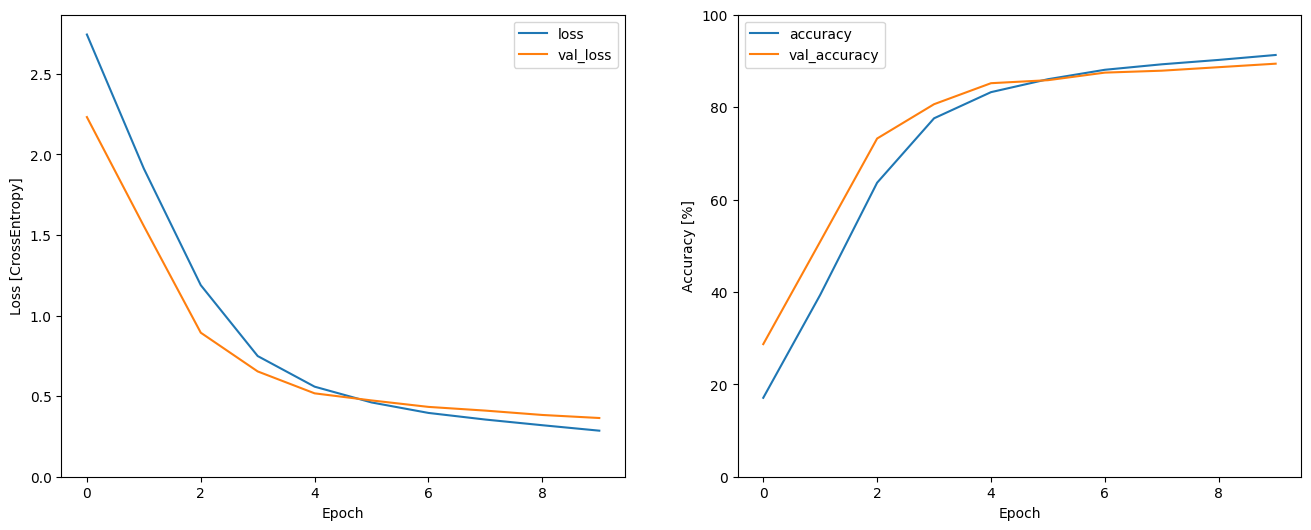

In [23]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [24]:
model.evaluate(test_spectrogram_ds, return_dict=True)

102/102 [==============================] - 8s 75ms/step - loss: 0.3586 - accuracy: 0.8977


{'loss': 0.3585604429244995, 'accuracy': 0.8977009654045105}

In [25]:
y_pred = model.predict(test_spectrogram_ds)

102/102 [==============================] - 13s 77ms/step


In [26]:
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

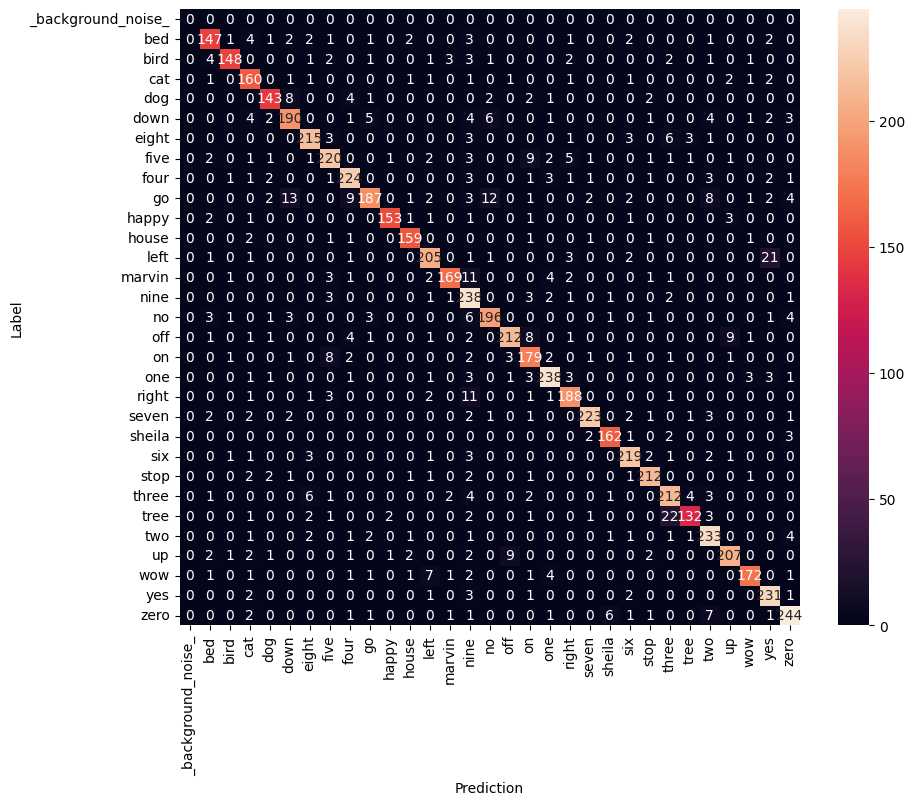

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

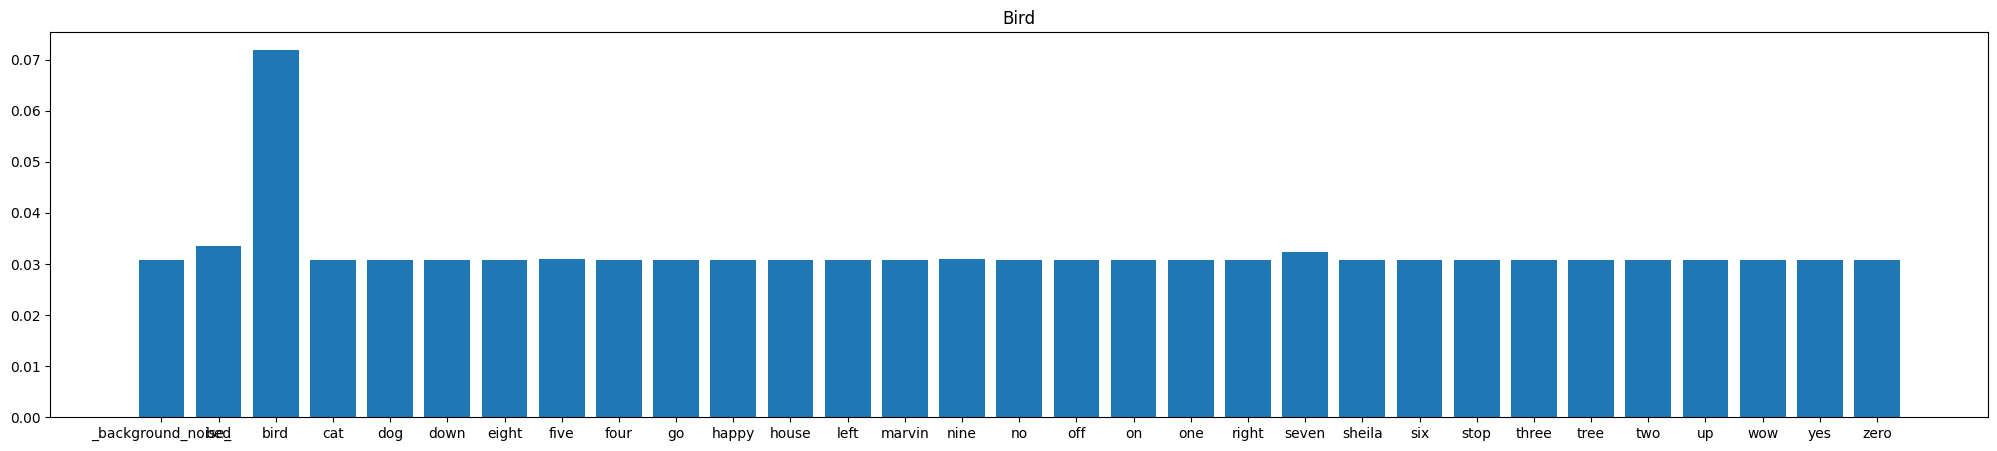

In [34]:
x = "data/bird/00f0204f_nohash_2.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

plt.figure(figsize=(25,5))
prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Bird')
plt.show()

display.display(display.Audio(waveform, rate=16000))